Created by Martin Knudsen (martin.knudsen(at)tum.de), July 2019.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as snb
from scipy import integrate
snb.set()

Lagrange Finite Elements.Consider a partition $−1 = x_0<x_1<···<x_k = 1,k≥1$, of the reference element[−1,1]

1. Write a Python-function that computes the Lagrange shape functions $l_{k,α}$ (i.e. the basis functions on the reference element) defined by $$l_{k,α}(x_β) =δ_{α,β}\quad 0≤β≤k,$$,for arbitrary $k≥1$. For this check out the numpy-routine numpy.poly1D and related commands. Compute also the derivatives of the shape functions.

This is only how the basis functions are within one basis element. the large basis functions actually span 2 elements. 

In [2]:
def lagrangeReference(k):
    '''
    Input: 
        k: degree of the basis functions
    Output: 
        basis: list of k+1 Lagrange polynomial basis function + their derivative in a tuple like: 
        [(l_k,0, l'_k,0),... ,(l_k,k, l'_k,k) ] on the interval [-1, 1]
    '''
    
    # use the numpy poly framework to get the polynomial with forced 1 as coeff of the highest variable degree
    # also return the derivative
    basis = []
    # there is always k+1 basis functions because then k is the degree
    xList = np.linspace(-1,1,k+1)
    for x in xList:
        # give all points for poly1d except the current point
        poly1 = np.poly1d([xi for xi in xList if xi!=x], r=True)
        # normalize by the current point to make sure the polynomial is 1 here
        poly1 = poly1/poly1(x)
        # derive using poly framework
        dpoly1 = np.polyder(poly1)
        basis.append((poly1, dpoly1))
    
    return basis

Lets see how the basis functions look within one element !

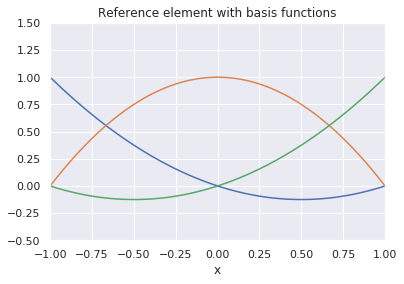

In [18]:
k=2
basis = lagrangeReference(k)
x = np.linspace(-1,1,100)
plt.figure()
plt.axis([-1,1, -0.5, 1.5])
plt.xlabel('x')
plt.title('Reference element with basis functions')

for i in range(k+1):
    plt.plot(x,basis[i][0](x))

How does the large basis function look in its entirety?

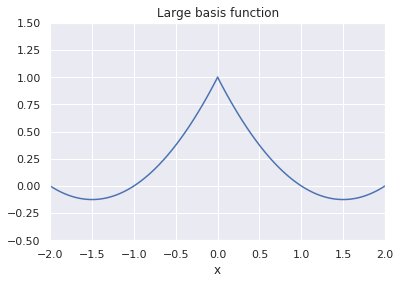

In [17]:
k=2
basis = lagrangeReference(k)
xLeft = np.linspace(-1,1,100)
xRight = np.linspace(0,2,100)
plt.figure()
plt.axis([-2,2, -0.5, 1.5])
plt.xlabel('x')
plt.title('Large basis function')
plt.plot(xLeft-1,basis[2][0](xLeft), 'b')
plt.plot(xRight,basis[0][0](xLeft), 'b')

2. Assemble the local mass matrix M and the local stiffness matrix S defined by $$M_{α,β}=\int^1_{−1}l_{k,α}l_{k,β}dx,\quad S_{α,β}=\int^1_{−1}l'_{k,α}l'_{k,β}dx,$$ where $l′_{k,α}$ denotes the derivative

In [5]:
def localMatrix(basis):
    '''
    Input: 
        basis: list of the basis functions of a reference element
    Output: 
        M: Mass matrix
        S: Stiffness matrix
    '''
    # the degree because we have one more basis function
    k = len(basis)-1
    # The local mass and stiffnes matrices consists of the integral of the product 
    # of each pair of each basis function or its derivative
    M = np.zeros((k+1, k+1))
    S = np.zeros((k+1, k+1))
    # iterate over each pair of basis-functions. Because the matrices are symmetric (the basis function are 
    # commutative, we only have the calculate the upper half)
    for a in range(k+1):
        for b in range(a, k+1):
            #integrate using poly framework
            integral = np.polyint(basis[a][0]*basis[b][0])
            dintegral = np.polyint(basis[a][1]*basis[b][1])
            # insert the boundaries
            M[a,b] = integral(1)-integral(-1)
            S[a,b] = dintegral(1)-dintegral(-1)
            # because of symmetry
            M[b,a] = M[a,b]
            S[b,a] = S[a,b]
            
    return M,S

Lets test it out for degree 2 functions

In [6]:
basis = lagrangeReference(2)
M, S = localMatrix(basis)
print('M')
print(M)
print('S')
print(S)

M
[[ 0.26666667  0.13333333 -0.06666667]
 [ 0.13333333  1.06666667  0.13333333]
 [-0.06666667  0.13333333  0.26666667]]
S
[[ 1.16666667 -1.33333333  0.16666667]
 [-1.33333333  2.66666667 -1.33333333]
 [ 0.16666667 -1.33333333  1.16666667]]


3. Implement a non-uniform partition $a=x0< x_1<···< x_N=b$ of the periodic domain $Ω = [a,b]⊂R$ into N elements. Each element $Ων= [xν,xν+1]$ can be mapped to the reference element via 
$$F_ν:  [−1,1]→[x_ν,x_{ν+1}]$$ $$x→\frac{x_ν+x_{ν+1}}{2}+\frac{(x_{ν+1}−x_ν)}{2}x.$$ 
Use the local matrices M and S to assemble the global mass matrix M and the global stiffness matrix S, defined by $$M_{i,j}=\int^1_{−1}l_{k,i}l_{k,j}dx,\quad S_{i,j}=\int^1_{−1}l'_{k,i}l'_{k,j}dx,$$
where $l_{k,α}=l_{k,i}◦F_ν$ with appropriate relations between local and global indices.

In [7]:
def globalMatrix(xvs, k):
    '''
    Input: 
        xvs: intervals of the elements
        k: degree of the basis functions
    Output: 
        M: Global mass matrix
        S: Global stiffness matrix
    '''
    # number of elements
    Nel = (len(xvs)-1)
    # number of to basis function chunks in total counting each element
    Ntot = Nel*(k+1)
    # number of basis functions. Because every knot "shares" a basis function
    # to the neighbouring elements
    Nb = Ntot - Nel 
    
    # init global matrix
    M = np.zeros((Nb,Nb))
    S = np.zeros((Nb,Nb))
    # get the local basis elements and mass matrices + stiffness matrices
    basis = lagrangeReference(k)
    MLocal, SLocal = localMatrix(basis)
    # iterate over all pairs of basisfunctions within each element
    for v in range(Nel):
        for a in range(k+1):
            for b in range(k+1):
                # transform the local to global coordinates
                i = k*v + a
                j = k*v + b
                # the local matrices are transformed into their contribution to the global matrix 
                # according to the formula of page 44 of the script
                M[i%Nb,j%Nb] += (xvs[v+1]-xvs[v])/2*MLocal[a,b]
                S[i%Nb,j%Nb] += 2/(xvs[v+1]-xvs[v])*SLocal[a,b]
    
    return M,S               

Lets test that out

In [8]:
intervals = np.linspace(-np.pi, np.pi, 4+ 1)
M, S = globalMatrix(intervals,k=2)
print(M)

[[ 0.41887902  0.10471976 -0.05235988  0.          0.          0.
  -0.05235988  0.10471976]
 [ 0.10471976  0.83775804  0.10471976  0.          0.          0.
   0.          0.        ]
 [-0.05235988  0.10471976  0.41887902  0.10471976 -0.05235988  0.
   0.          0.        ]
 [ 0.          0.          0.10471976  0.83775804  0.10471976  0.
   0.          0.        ]
 [ 0.          0.         -0.05235988  0.10471976  0.41887902  0.10471976
  -0.05235988  0.        ]
 [ 0.          0.          0.          0.          0.10471976  0.83775804
   0.10471976  0.        ]
 [-0.05235988  0.          0.          0.         -0.05235988  0.10471976
   0.41887902  0.10471976]
 [ 0.10471976  0.          0.          0.          0.          0.
   0.10471976  0.83775804]]


4. Test your global mass matrix by means of $L^2-$projection of the function $f: [−π,π]→R$ given by $$f(x) =\frac{sin(x)}{cos(x)/2 + 1}.$$ Assume a uniform grid and make a convergence plot as $h= 2π/N→0$.

First we have fo create the rightSide of the global system

In [9]:
def rightSide(xs, k, f):
    '''
    Input:
        xs: the intervals of the elements
        k: the degree of the basis functions
        f: the functions to multiply
    Output:
        b: the right side of the resulting liniear system    
    '''
    # number of elements
    Nel = (len(xs)-1)
    # number of to basis function chunks in total counting each element
    Ntot = Nel*(k+1)
    # number of basis functions. Because every knot "shares" a basis function
    # to the neighbouring elements
    Nb = Ntot - Nel 
    
    # get the basis functions
    basis = lagrangeReference(k)
    b=np.zeros(Nb)
    # iterate over all chunks of basis functions in each element
    for v in range(Nel):
        for a in range(k+1):
            # transform function into the [-1,1] interval
            funTransform = lambda x: f(xs[v]+(xs[v+1]-xs[v])/2*(x+1))
            # the function that should be integrated which is the function multiplied by the relevant basis
            intFun = lambda x: funTransform(x)*basis[a][0](x)
            # integrate using the quad function
            integral = integrate.quad(intFun,-1,1)
            # transform from local to global indices
            i=k*v+a
            # add the transformed version on th global system
            b[i%Nb] += (xs[v+1]-xs[v])/2*integral[0]
    return b 

Now we need a function that given the calculated weights of the global system can spit out some points for plotting

In [10]:
def funEval(intervals, fs, k):
    '''
    Input:
        intervals: the intervals of the elements
        fs: the calculated weights of the global system
        k: the degree of the basis functions
    Output:
        xList: list of points 
        fx: function evaluated on those points
    '''
    Nb = len(fs)
    basis = lagrangeReference(k)
    N = 500
    xList = np.linspace(intervals[0],intervals[-1], N)
    fx = np.zeros(N)
    # use the digitize function to divide all the x's into the element intervals
    bins = np.digitize(xList,intervals)
    # iterate over all the basis chunks of each element. the N-1 is because the last point always get
    # digitized into a bin that's not existing, this is maybe a bug
    for i in range(N-1):
        for a in range(k+1):
            # points belonging to which element
            idx = (bins[i]-1)*k + a
            
            # use which element this point belong to 
            fx[i] += fs[idx%Nb]*basis[a][0](2*(xList[i] - intervals[bins[i] - 1])\
            /(intervals[bins[i]] - intervals[bins[i] - 1]) - 1. ) 
    return xList, fx

Now we test it for different values of N

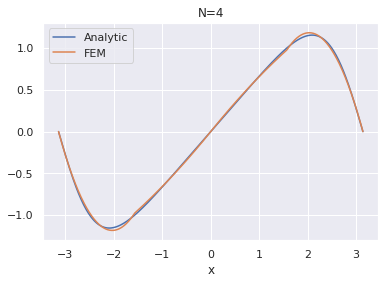

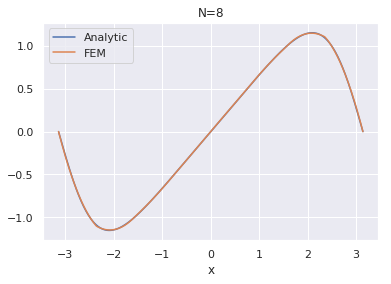

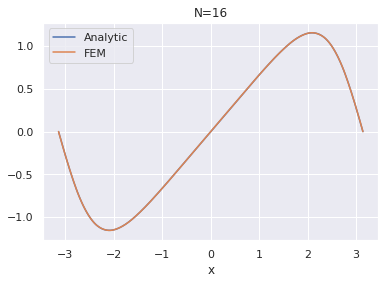

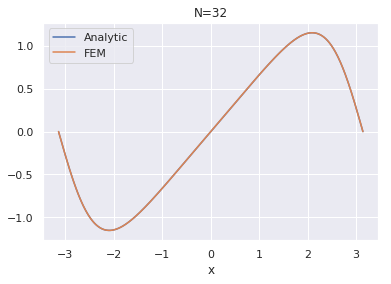

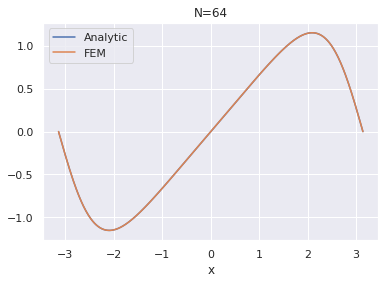

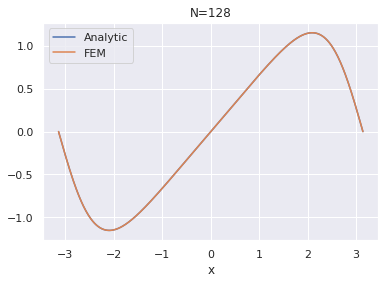

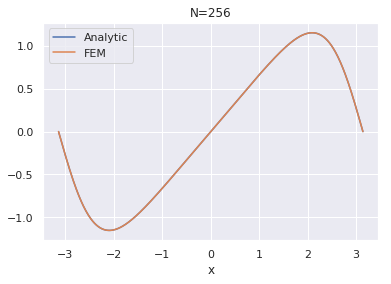

In [11]:
# testfunction
f = lambda x: np.sin(x)/(np.cos(x)/2+1)
# for different number of elements
# errors of the differenct cases (N x norm-type)
Ns = [2**i for i in range(2,9)]
errors = np.zeros((len(Ns), 3))
for i, N in enumerate(Ns):
    # the elements
    intervals = np.linspace(-np.pi, np.pi, N+1)
    # get the global matrix
    M,S = globalMatrix(intervals, k=2)
    # the rightside 
    b = rightSide(intervals, 2, f)
    # solve the linear system 
    fs = np.linalg.solve(M,b)
    # evauluate the function at different points in the interval using the calculated weights
    x, fx = funEval(intervals, fs, k=2)
    # plotting stuff
    plt.figure()
    plt.title('N='+str(N))
    plt.xlabel('x')
    plt.plot(x, f(x))
    plt.plot(x, fx)
    plt.legend(['Analytic','FEM'])
    
    # save the errors
    errors[i,0] = np.linalg.norm(fx-f(x), ord=1)
    errors[i,1] = np.linalg.norm(fx-f(x), ord=2)
    errors[i,2] = np.linalg.norm(fx-f(x), ord=np.inf)

make a convergence plot to see how the different errors change with the stepsize

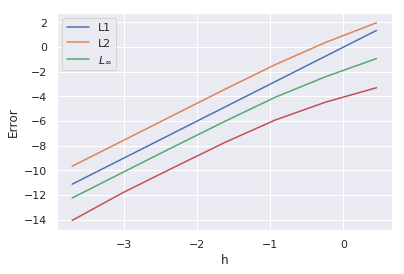

In [24]:
hs = [2*np.pi/N for N in Ns]
plt.plot(np.log(hs),np.log([h**3 for h in hs]))
plt.plot(np.log(hs), np.log(errors[:,0]))
plt.plot(np.log(hs), np.log(errors[:,1]))
plt.plot(np.log(hs), np.log(errors[:,2]))
plt.xlabel('h')
plt.ylabel('Error')
plt.legend(['L1', 'L2','$L_\infty$'])